Yuhang Fan Final Project

**Index**
1. [Get the Data](#Get-the-Data)
- [Have a look of data](#Have-a-look-of-data)
- [Define the performance metric](#Define-the-performance-metric)
- [Take a look at other data files and select some as part of data](#Take-a-look-at-other-data-files-and-select-some-as-part-of-data)
- [Create Test Set](#Create-Test-Set)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Prepare Data](#Prepare-Data)
- [Data Cleaning](#Data-Cleaning)
4. [Creating,testing and evaluating models](#Creating,testing-and-evaluating-models)
- [Scaling](#Scaling) function
- [Feature Engineering](#Feature-Engineering) function
- [Error Analysis](#Error-Analysis) function
- [1. Model 0](#1.-Model-0): Base model (20 observation, only AAPL's return as feature, simple Neural Network: only Dense layers)
- [2. Model 1](#2.-Model-1): (20 observation, AAPL's features + Other stocks features, simple Neural Network:CNN+Dense)
- [3. Model 2](#3.-Model-2): (50 observation, AAPL's features + Other stocks features, Neural Network: CNN + Dense)
- [4. Model 3](#4.-Model-3): (50 observation, AAPL's features + Other stocks features, More complex Neural Network: more (CNN + Dense))
- [5. Model 4](#5.-Model-4): (50 observation, AAPL's features + Other stocks features, More complex Neural Network (only LSTM)) -- Final Model
- [6. Model 5](#6.-Model-5): (50 observation, AAPL's features + Other stocks features + Feature Engineering, More complex Neural Network : more (CNN + Dense))
- [7. Model 6](#7.-Model-6): (50 observation, AAPL's features + Other stocks features + Feature Engineering, More complex Neural Network : more (CNN + Dense + LSTM))
- [8. Model 7](#8.-Model-7): (50 observation, AAPL's features + Other stocks features + Feature Engineering, LSTM model))
5. [Submission and Evaluation](#Submission-and-Evaluation)

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# Get the Data

In [2]:
df = pd.read_csv('Data/train/AAPL.csv')

### Have a look of data

In [3]:
df.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
dtypes: float64(8), object(1)
memory usage: 300.9+ KB


In [5]:
df.shape

(4277, 9)

In [6]:
# Check nan value
df.isnull().sum()

Dt           0
Adj Close    0
Close        0
Div          0
Factor       0
High         0
Low          0
Open         0
Volume       0
dtype: int64

### Define the performance metric

- The goal of this project is to predict next day stock return of AAPL
- This is a Regression task 
- I plan to use root mean square error (RMSE) as metric to evaluate the model
- I will also consider correct percentage of prediction direction 

In [7]:
# Add feature 'return' as the percent change of adjust close price
# 'Adj Close' is a more safe choice to calculate return, since there is no dividend or stock split issue involved 
df['return'] = df['Adj Close'].pct_change()

# Set Dt as index
df = df.set_index('Dt')

In [8]:
df.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return
Dt,,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN
2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318
2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630
2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546
2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390


### Take a look at other data files and select some as part of data

In [9]:
# Print out the csv files in data
Data_dir = './Data/train'
all_tickers = os.listdir(os.path.join(Data_dir))
for t in all_tickers:
    print(t)

CSCO.csv
V.csv
ADBE.csv
XLE.csv
INTC.csv
XLF.csv
XLP.csv
MSFT.csv
ACN.csv
XLB.csv
XLU.csv
NVDA.csv
XLV.csv
FB.csv
IBM.csv
XLY.csv
XLK.csv
SPY.csv
XLI.csv
GOOG.csv
XLRE.csv
MA.csv
AAPL.csv
CRM.csv


Select some files of stocks or index as our data to help predict next day return of AAPL  
- Stocks which are similar as AAPL (Big tech companies): GOOG, MSFT, IBM, FB, NVDA, ADBE, CSCO, CRM, INTC
- Indexes which are related to AAPL: XLK, SPY

In [10]:
# Add return, volume change, and amount change of other Stock or index as additional features
select_ticker_files = ['GOOG.csv','MSFT.csv','IBM.csv','ADBE.csv','CSCO.csv','CRM.csv',
                       'INTC.csv','NVDA.csv','FB.csv','SPY.csv','XLK.csv']

For data from other files

In [11]:
def merge_other_data(file_li,df,dirc):
    for file in file_li:
        data = pd.read_csv(os.path.join(dirc,file))
        company_ticker = file.split('.')[0]
        # return
        ret_col_name = company_ticker +'_return'
        data[ret_col_name] = data['Adj Close'].pct_change()
        # volume change
        volume_change_col_name = company_ticker +'_volume_change'
        data[volume_change_col_name]= data['Volume'].pct_change()
        # amount change
        amount_change_col_name = company_ticker +'_amount_change'
        data[amount_change_col_name]= (data['Close']*data['Volume']).pct_change()

        data = data.set_index('Dt')

        df[ret_col_name] = data[ret_col_name]
        df[volume_change_col_name] = data[volume_change_col_name]
        df[amount_change_col_name] = data[amount_change_col_name]

In [12]:
merge_other_data(select_ticker_files,df,Data_dir)

In [13]:
df.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return,GOOG_return,...,NVDA_amount_change,FB_return,FB_volume_change,FB_amount_change,SPY_return,SPY_volume_change,SPY_amount_change,XLK_return,XLK_volume_change,XLK_amount_change
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,NaN,...,-0.028099,NaN,NaN,NaN,-0.039106,-0.009125,-0.047878,-0.050733,-0.418505,-0.448011
2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,NaN,...,-0.393799,NaN,NaN,NaN,0.001789,0.505340,0.508033,-0.014847,2.494042,2.442188
2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,NaN,...,-0.402082,NaN,NaN,NaN,-0.016071,-0.488647,-0.496866,-0.033150,-0.123820,-0.152871
2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,NaN,...,-0.399308,NaN,NaN,NaN,0.058076,0.295365,0.370595,0.017455,-0.589222,-0.582051


In [14]:
df.isnull().sum()

Adj Close                0
Close                    0
Div                      0
Factor                   0
High                     0
Low                      0
Open                     0
Volume                   0
return                   1
GOOG_return           1163
GOOG_volume_change    1163
GOOG_amount_change    1163
MSFT_return              1
MSFT_volume_change       1
MSFT_amount_change       1
IBM_return               1
IBM_volume_change        1
IBM_amount_change        1
ADBE_return              1
ADBE_volume_change       1
ADBE_amount_change       1
CSCO_return              1
CSCO_volume_change       1
CSCO_amount_change       1
CRM_return            1123
CRM_volume_change     1123
CRM_amount_change     1123
INTC_return              1
INTC_volume_change       1
INTC_amount_change       1
NVDA_return              1
NVDA_volume_change       1
NVDA_amount_change       1
FB_return             3115
FB_volume_change      3115
FB_amount_change      3115
SPY_return               1
S

### Create Test Set 

In [15]:
# I split data into 80% train and 20% test
test_size = 0.2
total_length = len(df)
# Reset index to make Dt as a column
df = df.reset_index()
df['Dt'] = df['Dt'].apply(lambda x: int(x.replace('-','')))

test_length = int(total_length*test_size)
df_train = df.iloc[:total_length-test_length]
df_test = df.iloc[total_length-test_length:]

In [16]:
print('Shape of train dataset: ', df_train.shape )
print('Shape of test dataset: ', df_test.shape )

Shape of train dataset:  (3422, 43)
Shape of test dataset:  (855, 43)


# Exploratory Data Analysis

In [17]:
# Plot the cummulative return
df_train_EDA = df_train.copy()
df_train_EDA.loc[:,'cum_return'] = np.cumprod(1+df_train_EDA['return'])

<AxesSubplot:>

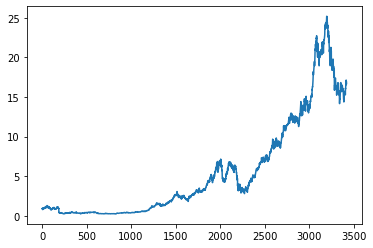

In [18]:
df_train_EDA['cum_return'].plot()

<AxesSubplot:>

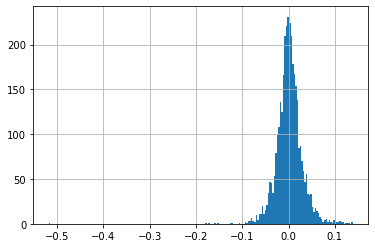

In [19]:
# Histogram of return
df_train_EDA['return'].hist(bins=200)

In [20]:
return_li = []
for col in df_train_EDA.columns:
    if 'return' in col:
        return_li.append(col)
print(return_li)

['return', 'GOOG_return', 'MSFT_return', 'IBM_return', 'ADBE_return', 'CSCO_return', 'CRM_return', 'INTC_return', 'NVDA_return', 'FB_return', 'SPY_return', 'XLK_return', 'cum_return']


In [21]:
# corr matrix between return of stocks and indexes
df_train_EDA[return_li].corr()

,return,GOOG_return,MSFT_return,IBM_return,ADBE_return,CSCO_return,CRM_return,INTC_return,NVDA_return,FB_return,SPY_return,XLK_return,cum_return
return,1.000000,0.471072,0.421914,0.414079,0.405569,0.454775,0.373122,0.495175,0.388990,0.064452,0.508398,0.601758,0.001113
GOOG_return,0.471072,1.000000,0.447525,0.402464,0.449421,0.433690,0.365352,0.416677,0.383518,0.042695,0.560490,0.599293,-0.016101
MSFT_return,0.421914,0.447525,1.000000,0.504885,0.503868,0.564808,0.410647,0.599245,0.440398,-0.004185,0.661557,0.737527,0.010827
IBM_return,0.414079,0.402464,0.504885,1.000000,0.460190,0.529107,0.440954,0.539040,0.424060,0.062784,0.640667,0.701985,0.009748
ADBE_return,0.405569,0.449421,0.503868,0.460190,1.000000,0.539099,0.443503,0.501824,0.429161,0.061334,0.574139,0.660903,-0.001358
CSCO_return,0.454775,0.433690,0.564808,0.529107,0.539099,1.000000,0.455900,0.633141,0.487059,0.054787,0.636988,0.798991,0.009033
CRM_return,0.373122,0.365352,0.410647,0.440954,0.443503,0.455900,1.000000,0.450921,0.414968,0.205121,0.541675,0.570355,-0.003010
INTC_return,0.495175,0.416677,0.599245,0.539040,0.501824,0.633141,0.450921,1.000000,0.528741,0.078258,0.654804,0.792619,0.001253
NVDA_return,0.388990,0.383518,0.440398,0.424060,0.429161,0.487059,0.414968,0.528741,1.000000,0.136041,0.501816,0.614102,-0.015860
FB_return,0.064452,0.042695,-0.004185,0.062784,0.061334,0.054787,0.205121,0.078258,0.136041,1.000000,0.096587,0.097472,-0.029201


<AxesSubplot:>

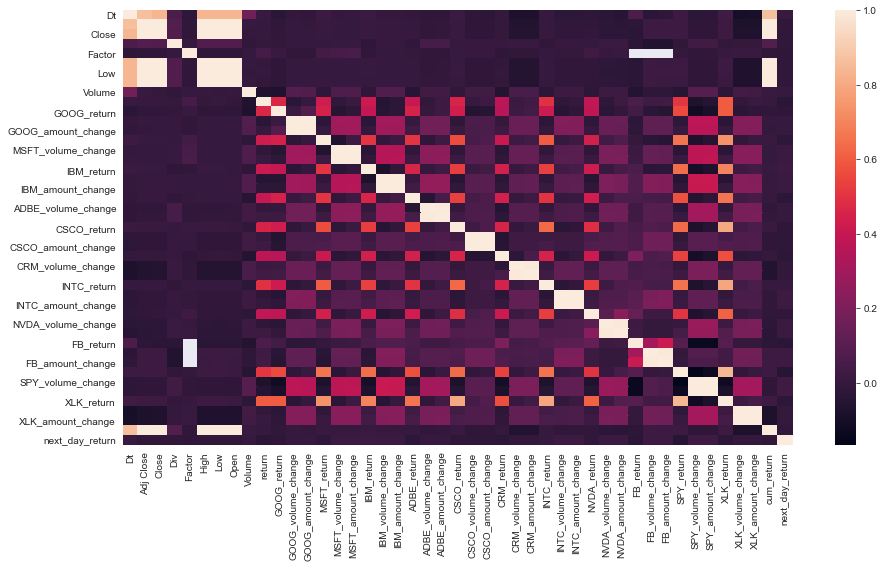

In [22]:
df_train_EDA['next_day_return'] = df_train_EDA['return'].shift(-1)
sns.set({'figure.figsize':(15,8)})
sns.heatmap(df_train_EDA.corr())

In [23]:
s = df_train_EDA.corr()['next_day_return']
s[abs(s)>0.02]

return               -0.035376
MSFT_return          -0.024850
ADBE_return          -0.029784
CSCO_volume_change   -0.023264
CSCO_amount_change   -0.023222
CRM_return           -0.026516
FB_return            -0.032110
FB_volume_change      0.022338
SPY_return           -0.046186
SPY_volume_change     0.027336
SPY_amount_change     0.025778
XLK_return           -0.027344
next_day_return       1.000000
Name: next_day_return, dtype: float64

The features above have a stronger correlation with AAPL's next day return compared with other features  

# Prepare Data

### Data Cleaning

In [24]:
# Fill nan values with median for both train and test
df_train = df_train.copy()
for col in df_train.columns:
    df_train.loc[:,col].fillna(df_train[col].median(),inplace=True)

df_test = df_test.copy()
for col in df_test.columns:
    df_test.loc[:,col].fillna(df_test[col].median(),inplace=True)

# Creating,testing and evaluating models

Some functions to use:

### Scaling
- Standardize the data
- Decide numbers of observations and create X_train, y_train

In [25]:
def create_data(data,label,num_obser):
    X = []
    Y = []
    for i in range(len(data)-num_obser):
        # Normalize every data which is used to predict return
        # Data is previous data to future return --> No looking into the future
        scaler=MinMaxScaler(feature_range=(0,1))
        X.append(scaler.fit_transform(data.iloc[i:i+num_obser]))
        Y.append(label.iloc[i+num_obser])
        
    return np.array(X), np.array(Y)

- Calculate percent of correct direction prediction

In [26]:
def calculate_correct_direction_prediction(y_predict,y_actual):
    right_count = 0
    for i in range(len(y_predict)):
        if (y_predict[i]) > 0 and (y_actual[i]) > 0:
            right_count += 1
        elif (y_predict[i]) < 0 and (y_actual[i]) < 0:
            right_count += 1
        else:
            continue

    return 100*(right_count/len(y_predict))

### Feature Engineering

In [27]:
def generate_features(df):
    df_copy = df.copy()
    # The difference between High and Low of AAPL
    df_copy['High_Low_diff'] = df_copy['High'] - df_copy['Low']
    
    # Moving Average & EMA of 5 & 20 trading days return for all tickers
    return_li = []
    for col in df_copy.columns:
        if 'return' in col:
            return_li.append(col)
    for ret in return_li:
        df_copy[ret+'_MA5'] = df_copy[ret].rolling(5).mean()
        df_copy[ret+'_MA20'] = df_copy[ret].rolling(20).mean()
        df_copy[ret+'_EMA5'] = df_copy[ret].ewm(span=5).mean()
        df_copy[ret+'_EMA20'] = df_copy[ret].ewm(span=20).mean()
        
    return df_copy

### Error Analysis
- Plot for train and test predicted return distribution
- Calculate in sample, out of sample RMSE
- Calculate percent of correct direction prediction

In [28]:
def error_analyis(model,X_train,X_test,y_train,y_test):
    train_ret = model.predict(X_train)
    test_ret = model.predict(X_test)
    
    # Calculate in sample, out of sample RMSE
    print("RMSE for in sample prediction: ",np.sqrt(mean_squared_error(y_train,train_ret)))
    print("RMSE for out of sample prediction: ",np.sqrt(mean_squared_error(y_test,test_ret)))
    
    # Calculate percent of correct direction prediction
    print("Correct direction in sample prediction % is: ", calculate_correct_direction_prediction(train_ret,y_train))
    print("Correct direction out of sample prediction % is: ", calculate_correct_direction_prediction(test_ret,y_test))

    # Creating plot for train and test predicted return distribution
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize =(12,6))
    
    ax1.hist(test_ret, bins = 200,label='Predict test return',density=True,alpha=0.8)
    ax1.hist(y_test, bins = 200, label='Actual test return',density=True,alpha=0.8)

    ax1.set_title("Return Histogram")
    ax1.set_facecolor('white')
    ax1.legend()
    
    # Plot predicted test return and real test return
    ax2.plot(y_test,label="Real_return")
    ax2.plot(test_ret,label="Predicted_return")
    ax2.set_title("Return Plot")
    ax2.set_facecolor('white')
    ax2.legend()


## 1. Model 0
Base model (20 observation, only AAPL's return as feature, simple Neural Network: only Dense layers)

In [29]:
# Create data and label for train set
data_train_model0 = df_train[['return']]
label_train_model0 = df_train['return']
number_observation_model0 = 20

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model0, label_train_model0, number_observation_model0)

# Transfering test data
# Create data and label for test set
data_test_model0 = df_test[['return']]
label_test_model0 = df_test['return']

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model0, label_test_model0, number_observation_model0)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3402, 20, 1)
Shape of y_train: (3402,)
Shape of X_test: (835, 20, 1)
Shape of y_test: (835,)


In [30]:
model0 = Sequential()
model0.add(Input(shape=number_observation_model0))
model0.add(Dense(32,activation='relu'))          
model0.add(Dense(1))           
    
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [31]:
loss = 'mean_squared_error'
max_epochs = 10

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model0.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss',min_delta=.00001, patience=3,
                            verbose=0, mode='auto',baseline=None,
                            restore_best_weights=True)

history0 = model0.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/10
96/96 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0065
Epoch 2/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 3/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 5/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 6/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/10
96/96 [==============================] - 0s 920us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 8/10
96/96 [==============================] - 0s 907us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/10
96/96 [==============================] - 0s 919us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/10
96/96 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.8461e-04


RMSE for in sample prediction:  0.030443592243328446
RMSE for out of sample prediction:  0.019275330019765842
Correct direction in sample prediction % is:  50.88183421516755
Correct direction out of sample prediction % is:  48.383233532934135


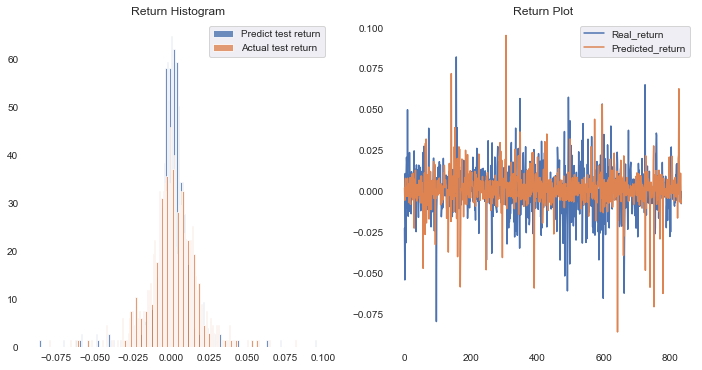

In [32]:
error_analyis(model0,X_train,X_test,y_train,y_test)

- I conducted the experiments multiple times, and I found that Model0 had relative high RMSE for both in sample and out of sample prediction
- The In sample RMSE is always higher than out of sample RMSE, which suggests the model is underfitted
- More features or more complex model should be considered in next steps

## 2. Model 1
(20 observation, AAPL's features + Other stocks features, simple Neural Network:CNN+Dense)

In [33]:
# Create data and label for train set
data_train_model1 = df_train.drop(columns='return')
label_train_model1 = df_train['return']
number_observation_model1 = 20

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model1, label_train_model1, number_observation_model1)

# Transfering test data
# Create data and label for test set
data_test_model1 = df_test.drop(columns='return')
label_test_model1 = df_test['return']

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model1, label_test_model1, number_observation_model1)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3402, 20, 42)
Shape of y_train: (3402,)
Shape of X_test: (835, 20, 42)
Shape of y_test: (835,)


In [34]:
model1 = Sequential()
model1.add(Conv1D(filters=32, kernel_size=3, padding="same", input_shape=X_train.shape[1:]))
# model1.add(Flatten())     
model1.add(Dense(32,activation='relu')) 
model1.add(Flatten())     
model1.add(Dense(1))         
    
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            4064      
                                                                 
 dense_2 (Dense)             (None, 20, 32)            1056      
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 641       
                                                                 
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
_________________________________________________________________


In [35]:
loss = 'mean_squared_error'
max_epochs = 15

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model1.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss',min_delta=.00001, patience=3,
                            verbose=0, mode='auto',baseline=None,
                            restore_best_weights=True)

history1 = model1.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/15
96/96 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0028
Epoch 2/15
96/96 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 7.5395e-04
Epoch 3/15
96/96 [==============================] - 0s 2ms/step - loss: 8.4300e-04 - val_loss: 7.7555e-04
Epoch 4/15
96/96 [==============================] - 0s 2ms/step - loss: 8.5600e-04 - val_loss: 7.5900e-04
Epoch 5/15
96/96 [==============================] - 0s 2ms/step - loss: 8.4031e-04 - val_loss: 7.7634e-04


RMSE for in sample prediction:  0.028756542229512846
RMSE for out of sample prediction:  0.015938969211309117
Correct direction in sample prediction % is:  52.4103468547913
Correct direction out of sample prediction % is:  51.616766467065865


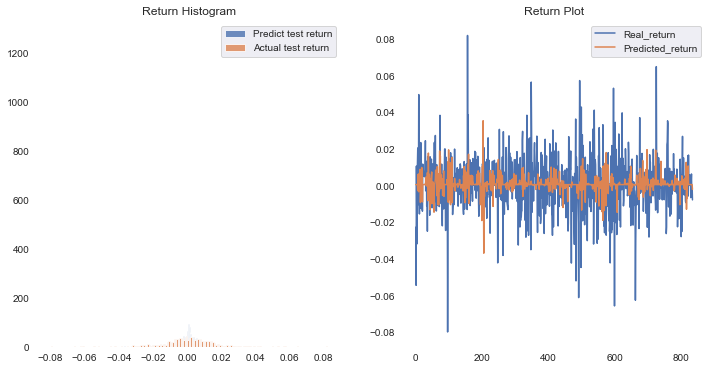

In [36]:
error_analyis(model1,X_train,X_test,y_train,y_test)

- Through several experients, I found that the model1 always perform better than base model
- It may due to the fact that I added more features to the model and added a CNN layer to the model
- Right now I am using 20 observations from past, I could try more observation next

## 3. Model 2
(50 observation, AAPL's features + Other stocks features, Neural Network: CNN + Dense)

In [37]:
# Create data and label for train set
data_train_model2 = df_train.drop(columns='return')
label_train_model2 = df_train['return']
number_observation_model2 = 50

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model2, label_train_model2, number_observation_model2)

# Transfering test data
# Create data and label for test set
data_test_model2 = df_test.drop(columns='return')
label_test_model2 = df_test['return']

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model2, label_test_model2, number_observation_model2)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3372, 50, 42)
Shape of y_train: (3372,)
Shape of X_test: (805, 50, 42)
Shape of y_test: (805,)


In [38]:
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=3, padding="same", input_shape=X_train.shape[1:]))
model2.add(Dense(32,activation='relu')) 
model2.add(Flatten())     
model2.add(Dense(1))         
    
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 32)            4064      
                                                                 
 dense_4 (Dense)             (None, 50, 32)            1056      
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1601      
                                                                 
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


In [39]:
loss = 'mean_squared_error'
max_epochs = 20

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model2.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss', min_delta=.00001, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history2 = model2.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/20
95/95 [==============================] - 1s 4ms/step - loss: 0.0188 - val_loss: 9.0870e-04
Epoch 2/20
95/95 [==============================] - 0s 2ms/step - loss: 8.9473e-04 - val_loss: 6.7761e-04
Epoch 3/20
95/95 [==============================] - 0s 2ms/step - loss: 8.4164e-04 - val_loss: 6.7498e-04
Epoch 4/20
95/95 [==============================] - 0s 2ms/step - loss: 8.3540e-04 - val_loss: 7.0166e-04
Epoch 5/20
95/95 [==============================] - 0s 2ms/step - loss: 8.3793e-04 - val_loss: 7.0976e-04


RMSE for in sample prediction:  0.02852412392848386
RMSE for out of sample prediction:  0.01508440156247629
Correct direction in sample prediction % is:  51.89798339264532
Correct direction out of sample prediction % is:  49.93788819875776


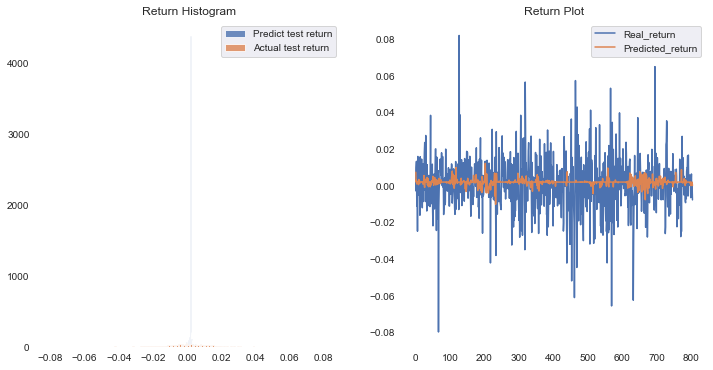

In [40]:
error_analyis(model2,X_train,X_test,y_train,y_test)

- RMSE for out of sample prediction improved a little compared to model1
- It suggests that increasing number of observation is some what useful
- At this stage, the RMSE for in sample is still higher than out of sample
- Maybe we can try more complex neural network 

## 4. Model 3
(50 observation, AAPL's features + Other stocks features, More complex Neural Network: more (CNN + Dense))

In [41]:
# Create data and label for train set
data_train_model3 = df_train.drop(columns='return')
label_train_model3 = df_train['return']
number_observation_model3 = 50

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model3, label_train_model3, number_observation_model3)

# Transfering test data
# Create data and label for test set
data_test_model3 = df_test.drop(columns='return')
label_test_model3 = df_test['return']

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model3, label_test_model3, number_observation_model3)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3372, 50, 42)
Shape of y_train: (3372,)
Shape of X_test: (805, 50, 42)
Shape of y_test: (805,)


In [42]:
model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, padding="same", input_shape=X_train.shape[1:]))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.1))
model3.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model3.add(Dropout(0.1))
model3.add(Dense(64))
model3.add(Flatten())
model3.add(Dense(1))           
    
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 50, 32)            4064      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 dropout_1 (Dropout)         (None, 25, 32)            0         
                                                                 
 dense_6 (Dense)             (None, 25, 64)            2112      
                                                      

In [43]:
loss = 'mean_squared_error'
max_epochs = 50

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model3.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss', min_delta=.00001, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history3 = model3.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/50
95/95 [==============================] - 1s 5ms/step - loss: 0.0993 - val_loss: 0.0077
Epoch 2/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0020
Epoch 3/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 4/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 5/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 6/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 7/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 8.8303e-04
Epoch 8/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 9.8537e-04
Epoch 10/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.3171e-04
Epoch 1

RMSE for in sample prediction:  0.028896001932756425
RMSE for out of sample prediction:  0.02241360675041222
Correct direction in sample prediction % is:  59.72716488730724
Correct direction out of sample prediction % is:  52.17391304347826


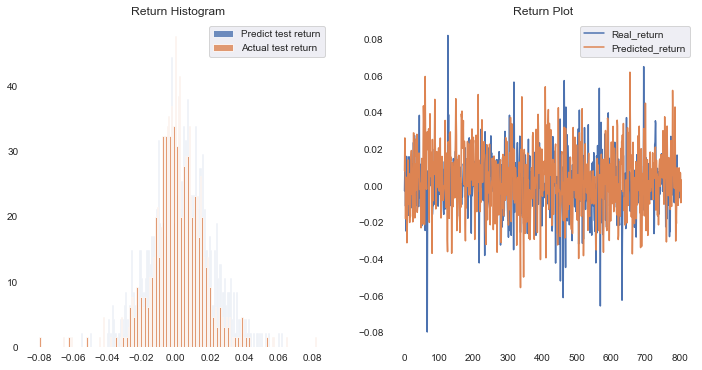

In [44]:
error_analyis(model3,X_train,X_test,y_train,y_test)

- Showing from the results of multiple experients, the RMSE for in sample prediction actually decreases
- And the Correct direction in sample prediction % increases a lot
- It suggests machine really learned something
- It is time to introduce LSTM layer into model. LSTM is able to transfer memory information so it is ideal model for this time series data prediction

## 5. Model 4
(50 observation, AAPL's features + Other stocks features, More complex Neural Network (only LSTM))

In [45]:
# Create data and label for train set
data_train_model4 = df_train.drop(columns='return')
label_train_model4 = df_train['return']
number_observation_model4 = 50

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model4, label_train_model4, number_observation_model4)

# Transfering test data
# Create data and label for test set
data_test_model4 = df_test.drop(columns='return')
label_test_model4= df_test['return']

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model4, label_test_model4, number_observation_model4)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3372, 50, 42)
Shape of y_train: (3372,)
Shape of X_test: (805, 50, 42)
Shape of y_test: (805,)


In [46]:
model4 = Sequential()
model4.add(LSTM(64,return_sequences=True,input_shape=(X_train.shape[1:])))
model4.add(LSTM(64,return_sequences=True))
model4.add(LSTM(64))
model4.add(Dense(1))           
    
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            27392     
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,505
Trainable params: 93,505
Non-trainable params: 0
_________________________________________________________________


In [47]:
loss = 'mean_squared_error'
max_epochs = 20

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model4.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss', min_delta=.000001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history4 = model4.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/20
95/95 [==============================] - 9s 52ms/step - loss: 0.0097 - val_loss: 7.6880e-04
Epoch 2/20
95/95 [==============================] - 4s 42ms/step - loss: 0.0011 - val_loss: 8.4936e-04
Epoch 3/20
95/95 [==============================] - 4s 42ms/step - loss: 8.8654e-04 - val_loss: 9.0511e-04
Epoch 4/20
95/95 [==============================] - 4s 42ms/step - loss: 8.7420e-04 - val_loss: 7.2598e-04
Epoch 5/20
95/95 [==============================] - 4s 44ms/step - loss: 8.5864e-04 - val_loss: 6.8688e-04
Epoch 6/20
95/95 [==============================] - 4s 43ms/step - loss: 8.5247e-04 - val_loss: 7.7701e-04
Epoch 7/20
95/95 [==============================] - 4s 43ms/step - loss: 8.4537e-04 - val_loss: 6.7383e-04
Epoch 8/20
95/95 [==============================] - 4s 42ms/step - loss: 8.3943e-04 - val_loss: 7.6879e-04
Epoch 9/20
95/95 [==============================] - 4s 47ms/step - loss: 8.4108e-04 - val_loss: 6.8098e-04
Epoch 10/20
95/95 [==========================

RMSE for in sample prediction:  0.02826607492216993
RMSE for out of sample prediction:  0.015148979327202104
Correct direction in sample prediction % is:  54.24080664294188
Correct direction out of sample prediction % is:  51.30434782608696


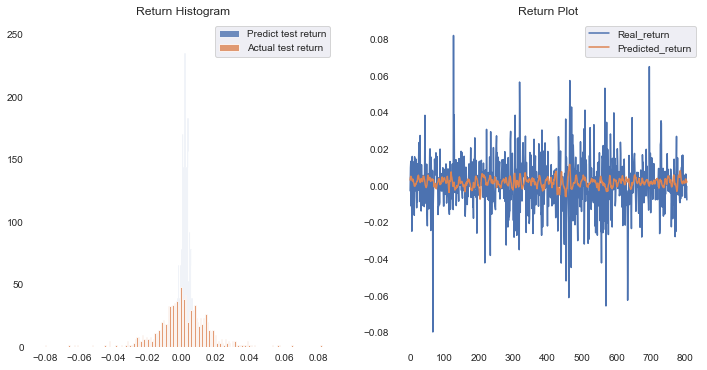

In [48]:
error_analyis(model4,X_train,X_test,y_train,y_test)

- RMSE for out of sample prediction of LSTM model is very low. And that is the best out of sample prediction so far
- At this stage, maybe generating more features will help improve the result

## 6. Model 5
(50 observation, AAPL's features + Other stocks features + Feature Engineering, More complex Neural Network : more (CNN + Dense))

In [49]:
# Feature Engineering to get more features
data_train_model5 = generate_features(df_train)

# Clean data
data_train_model5 = data_train_model5.copy()
for col in data_train_model5.columns:
    data_train_model5.loc[:,col].fillna(data_train_model5[col].median(),inplace=True)
    
# Create data and label for train set
label_train_model5 = data_train_model5['return']
data_train_model5 = data_train_model5.drop(columns='return')
number_observation_model5 = 50

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model5, label_train_model5, number_observation_model5)


# Transfering test data
# Feature Engineering to get more features
data_test_model5 = generate_features(df_test)

# Clean data
data_test_model5 = data_test_model5.copy()
for col in data_test_model5.columns:
    data_test_model5.loc[:,col].fillna(data_test_model5[col].median(),inplace=True)
    
# Create data and label for test set
label_test_model5 = data_test_model5['return']
data_test_model5 = data_test_model5.drop(columns='return')

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model5, label_test_model5, number_observation_model5)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3372, 50, 91)
Shape of y_train: (3372,)
Shape of X_test: (805, 50, 91)
Shape of y_test: (805,)


In [50]:
model5 = Sequential()
model5.add(Conv1D(filters=32, kernel_size=3, padding="same", input_shape=X_train.shape[1:]))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Dropout(0.1))
model5.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model5.add(Dropout(0.1))
model5.add(Dense(64))
model5.add(Flatten())
model5.add(Dense(1))           
    
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 50, 32)            8768      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 25, 32)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 dropout_3 (Dropout)         (None, 25, 32)            0         
                                                                 
 dense_9 (Dense)             (None, 25, 64)            2112      
                                                      

In [51]:
loss = 'mean_squared_error'
max_epochs = 50

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model5.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss', min_delta=.00001, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history5 = model5.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/50
95/95 [==============================] - 1s 6ms/step - loss: 0.2325 - val_loss: 0.0127
Epoch 2/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0300 - val_loss: 0.0032
Epoch 3/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0138 - val_loss: 0.0022
Epoch 4/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0018
Epoch 5/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0020
Epoch 6/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0010
Epoch 7/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 8/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 9/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0013


RMSE for in sample prediction:  0.03260798543624713
RMSE for out of sample prediction:  0.026579688113668114
Correct direction in sample prediction % is:  53.4994068801898
Correct direction out of sample prediction % is:  49.81366459627329


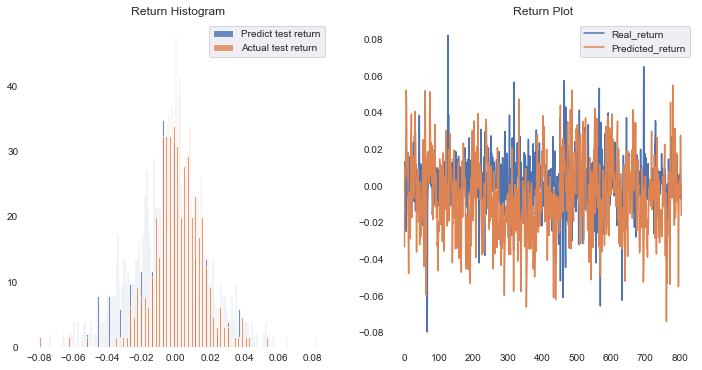

In [52]:
error_analyis(model5,X_train,X_test,y_train,y_test)

- Adding more features does not seem to improve the performance 
- Maybe try one more model with feature engineering and even more complex network

## 7. Model 6
(50 observation, AAPL's features + Other stocks features + Feature Engineering, More complex Neural Network : more (CNN + Dense + LSTM))

In [53]:
# Feature Engineering to get more features
data_train_model6 = generate_features(df_train)

# Clean data
data_train_model6 = data_train_model6.copy()
for col in data_train_model6.columns:
    data_train_model6.loc[:,col].fillna(data_train_model6[col].median(),inplace=True)
    
# Create data and label for train set
label_train_model6 = data_train_model6['return']
data_train_model6 = data_train_model6.drop(columns='return')
number_observation_model6 = 50

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model6, label_train_model6,number_observation_model6)


# Transfering test data
# Feature Engineering to get more features
data_test_model6 = generate_features(df_test)

# Clean data
data_test_model6 = data_test_model6.copy()
for col in data_test_model6.columns:
    data_test_model6.loc[:,col].fillna(data_test_model6[col].median(),inplace=True)
    
# Create data and label for test set
label_test_model6 = data_test_model6['return']
data_test_model6 = data_test_model6.drop(columns='return')

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model6, label_test_model6, number_observation_model6)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3372, 50, 91)
Shape of y_train: (3372,)
Shape of X_test: (805, 50, 91)
Shape of y_test: (805,)


In [54]:
model6 = Sequential()
model6.add(Conv1D(filters=64, kernel_size=3, padding="same", input_shape=X_train.shape[1:]))
model6.add(Dropout(0.1))
model6.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model6.add(Dropout(0.1))
model6.add(MaxPooling1D(pool_size=2))
model6.add(LSTM(64,return_sequences=True))
model6.add(Dense(64))
model6.add(Flatten())
model6.add(Dense(1))           
    
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 50, 64)            17536     
                                                                 
 dropout_4 (Dropout)         (None, 50, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 64)            12352     
                                                                 
 dropout_5 (Dropout)         (None, 50, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 25, 64)            33024     
                                                      

In [55]:
loss = 'mean_squared_error'
max_epochs = 50

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model6.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss', min_delta=.00001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history6 = model6.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/50
95/95 [==============================] - 3s 19ms/step - loss: 0.0777 - val_loss: 0.0011
Epoch 2/50
95/95 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 6.8681e-04
Epoch 3/50
95/95 [==============================] - 1s 16ms/step - loss: 8.6588e-04 - val_loss: 6.8317e-04
Epoch 4/50
95/95 [==============================] - 1s 15ms/step - loss: 9.7481e-04 - val_loss: 6.7719e-04
Epoch 5/50
95/95 [==============================] - 1s 16ms/step - loss: 8.3945e-04 - val_loss: 6.7867e-04
Epoch 6/50
95/95 [==============================] - 1s 15ms/step - loss: 8.4515e-04 - val_loss: 6.7638e-04
Epoch 7/50
95/95 [==============================] - 2s 16ms/step - loss: 8.4729e-04 - val_loss: 6.7953e-04
Epoch 8/50
95/95 [==============================] - 1s 15ms/step - loss: 8.4133e-04 - val_loss: 8.0879e-04
Epoch 9/50
95/95 [==============================] - 1s 15ms/step - loss: 8.4041e-04 - val_loss: 7.2114e-04
Epoch 10/50
95/95 [==============================

RMSE for in sample prediction:  0.02856834493073194
RMSE for out of sample prediction:  0.015117490772809558
Correct direction in sample prediction % is:  51.69039145907474
Correct direction out of sample prediction % is:  51.18012422360248


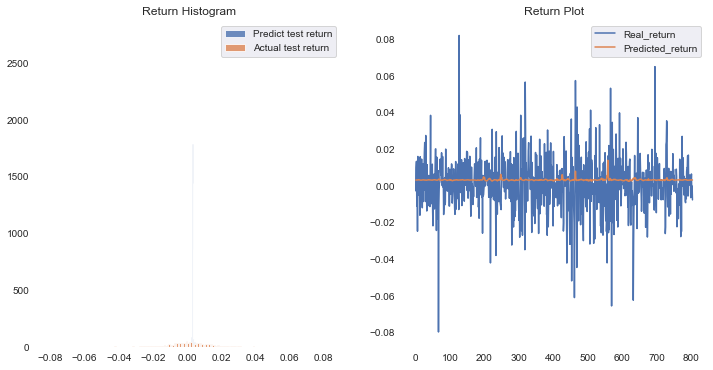

In [56]:
error_analyis(model6,X_train,X_test,y_train,y_test)

- So far this best model is still pure LSTM model
- Last model I will try fit LSTM model with feature engineering

## 8. Model 7
(50 observation, AAPL's features + Other stocks features + Feature Engineering, LSTM model))

In [57]:
# Feature Engineering to get more features
data_train_model7 = generate_features(df_train)

# Clean data
data_train_model7 = data_train_model7.copy()
for col in data_train_model7.columns:
    data_train_model7.loc[:,col].fillna(data_train_model7[col].median(),inplace=True)
    
# Create data and label for train set
label_train_model7 = data_train_model7['return']
data_train_model7 = data_train_model7.drop(columns='return')
number_observation_model7 = 50

# Standardize the data
# Decide numbers of observations and create X_train, y_train
X_train, y_train = create_data(data_train_model7, label_train_model7,number_observation_model7)


# Transfering test data
# Feature Engineering to get more features
data_test_model7 = generate_features(df_test)

# Clean data
data_test_model7 = data_test_model7.copy()
for col in data_test_model7.columns:
    data_test_model7.loc[:,col].fillna(data_test_model7[col].median(),inplace=True)
    
# Create data and label for test set
label_test_model7 = data_test_model7['return']
data_test_model7 = data_test_model7.drop(columns='return')

# Standardize the data
# Decide numbers of observations and create X_test, y_test
X_test, y_test = create_data(data_test_model7, label_test_model7, number_observation_model7)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3372, 50, 91)
Shape of y_train: (3372,)
Shape of X_test: (805, 50, 91)
Shape of y_test: (805,)


In [58]:
model7 = Sequential()
model7.add(LSTM(64,return_sequences=True,input_shape=(X_train.shape[1:])))
model7.add(LSTM(64,return_sequences=True))
model7.add(LSTM(64))
model7.add(Dense(1))           
    
model7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 64)            39936     
                                                                 
 lstm_5 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 106,049
Trainable params: 106,049
Non-trainable params: 0
_________________________________________________________________


In [59]:
loss = 'mean_squared_error'
max_epochs = 50

X_train_t, X_train_val, y_train_t, y_train_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model7.compile(loss=loss)
es_callback = EarlyStopping(monitor='val_loss', min_delta=.00001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history7 = model7.fit(X_train_t, y_train_t, 
                      epochs=max_epochs,
                      batch_size =32, 
                      validation_data=(X_train_val, y_train_val),
                      callbacks=[es_callback])

Epoch 1/50
95/95 [==============================] - 9s 54ms/step - loss: 0.0100 - val_loss: 7.7223e-04
Epoch 2/50
95/95 [==============================] - 4s 42ms/step - loss: 0.0010 - val_loss: 6.8825e-04
Epoch 3/50
95/95 [==============================] - 4s 42ms/step - loss: 8.8387e-04 - val_loss: 7.6618e-04
Epoch 4/50
95/95 [==============================] - 4s 42ms/step - loss: 8.7355e-04 - val_loss: 7.0624e-04
Epoch 5/50
95/95 [==============================] - 4s 44ms/step - loss: 8.5184e-04 - val_loss: 6.8545e-04
Epoch 6/50
95/95 [==============================] - 4s 44ms/step - loss: 8.4142e-04 - val_loss: 6.7330e-04
Epoch 7/50
95/95 [==============================] - 4s 44ms/step - loss: 8.3904e-04 - val_loss: 6.7186e-04
Epoch 8/50
95/95 [==============================] - 5s 47ms/step - loss: 8.2984e-04 - val_loss: 6.7336e-04
Epoch 9/50
95/95 [==============================] - 5s 53ms/step - loss: 8.2237e-04 - val_loss: 7.1304e-04
Epoch 10/50
95/95 [==========================

RMSE for in sample prediction:  0.02834261548443279
RMSE for out of sample prediction:  0.014985958167238637
Correct direction in sample prediction % is:  54.03321470937129
Correct direction out of sample prediction % is:  48.94409937888199


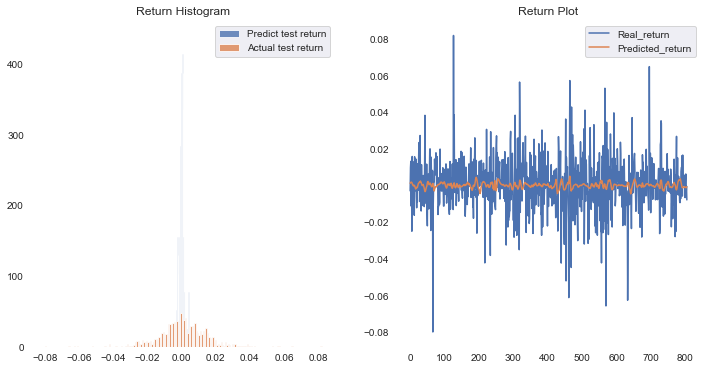

In [60]:
error_analyis(model7,X_train,X_test,y_train,y_test)

- After several experiments, I find that Model4 actually performs the best
- It has lowest out of sample prediction compared with other model
- It has correct direction prediction larger than 50% for both in sample and out sample
- Model4 will be selected as final model

## Submission and Evaluation

In [61]:
import os
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

modelName = "final_model"
model_path = os.path.join(".", modelName)
def create_data(data,label,num_obser):
    X = []
    Y = []
    for i in range(len(data)-num_obser):
        # Normalize every data which is used to predict return
        # Data is previous data to future return --> No looking into the future
        scaler=MinMaxScaler(feature_range=(0,1))
        X.append(scaler.fit_transform(data.iloc[i:i+num_obser]))
        Y.append(label.iloc[i+num_obser])
        
    return np.array(X), np.array(Y)

def merge_other_data(file_li,df,dirc):
    for file in file_li:
        data = pd.read_csv(os.path.join(dirc,file))
        company_ticker = file.split('.')[0]
        # return
        ret_col_name = company_ticker +'_return'
        data[ret_col_name] = data['Adj Close'].pct_change()
        # volume change
        volume_change_col_name = company_ticker +'_volume_change'
        data[volume_change_col_name]= data['Volume'].pct_change()
        # amount change
        amount_change_col_name = company_ticker +'_amount_change'
        data[amount_change_col_name]= (data['Close']*data['Volume']).pct_change()

        data = data.set_index('Dt')

        df[ret_col_name] = data[ret_col_name]
        df[volume_change_col_name] = data[volume_change_col_name]
        df[amount_change_col_name] = data[amount_change_col_name]
        
def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    df = pd.read_csv(test_dir+'/AAPL.csv')
    df['return'] = df['Adj Close'].pct_change()
    df = df.set_index('Dt')
    select_ticker_files = ['GOOG.csv','MSFT.csv','IBM.csv','ADBE.csv','CSCO.csv','CRM.csv',
                       'INTC.csv','NVDA.csv','FB.csv','SPY.csv','XLK.csv']
    merge_other_data(select_ticker_files,df,test_dir)
    ids = df.index
    df = df.reset_index()
    df['Dt'] = df['Dt'].apply(lambda x: int(x.replace('-','')))
    
    df = df.copy()
    for col in df.columns:
        df.loc[:,col].fillna(df[col].median(),inplace=True)
    
    observation = 50
    data = df.drop(columns='return')
    label = df['return']
    X, y = create_data(data, label, observation)
    predictions = model.predict(X)
    ids = ids[observation:]
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model4 # CHANGE None to your model !

saveModel(my_model, model_path)

Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


In [62]:
# Testing
holdout_dir = os.path.join(".", "Data", "sample")
predicts = MyModel(holdout_dir, model_path)

In [63]:
print("Done")

Done
